# Micrograd - Arnie's version

I built this project as a way to solidify my understanding of the Stanford/DeepLearningAI Coursera course.

Before taking the class (June start - July end), I had watched Andrej Karpathy's Micrograd lecture (around May), but not since then.

To really test my understanding, I built this out *without* re-watching Karpathy's lecture. That is, I built this with a rough understanding of autograd, and thought through first principles of differentiation, partial derivatives, chain_rule, software design, back_propagation, linear regression, optimizers, loss functions.

Note:
- I did have a working micrograd implementation, however my loss was incorrect.
- After manually calculating the backprop and still not figuring out, I skimmed through Karpathy's micrograd code.
- I took the opportunity to:
-> Add in additional methods I hand't thought like __sub__, __rsub__, ....
-> Clean-up my implementation of Neuron (notably, passing in input_feature and a single x sample, rather than the x as array itself)

In the end, I realized the problem was with that I forgot to call the zero_grad() which led to the loss bouncing since the grads were compounding across iterations

In principle, I don't take shortcuts, but given my urgency to progress as fast as possible in ML and since I already had a working implementation (with correct intuition), it did not make sense to spend more time debugging (I can always do that later).

Extra notes: Obviously I did not use Copilot xD.

In [1]:
# Install requirements

!pip install pydantic

## Operation Tests

In [2]:
from micrograd.engine.value import Value

a = Value(6.0)
b = Value(3.0)

c = a * b
print(c)

d = a / b
print(d)

e = Value(100.0)
f = e.log()
# print(f)

Val(value=18.0000, grad=0.0000, parents=(6.0 * 3.0))
Val(value=2.0000, grad=0.0000, parents=(6.0 * 0.3333333333333333))


In [3]:
f = f.log()
# print(f)

## Simple Linear Regression Example

In [4]:
from micrograd.nets.SimpleLinearRegression import SimpleLinearRegression
from micrograd.loss_functions.MSE import MSE
from micrograd.optimizers.SimpleOptimizer import SimpleOptimizer

from micrograd.engine.value import Value

# Set-up model, optimizers and loss function
model = SimpleLinearRegression()
criterion = MSE()

num_epochs = 1000
lr = 0.01

optimizer = SimpleOptimizer(model.parameters(), lr)

# Dataset
x = [Value(1.0), Value(4.0), Value(9.0)]
y = [Value(1.0), Value(8.0), Value(18.0)]

for epoch in range(num_epochs):
    # Need to applying the logistic activation!
    y_pred = [model([xi]) for xi in x]

    loss = criterion(y_pred, y)

    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.value:.4f}')

test_x = [Value(6.0)]
test_y_pred = model(test_x)

print(f"Prediction for x={test_x[0].value} is y_pred={test_y_pred.value} (Expected is 12)")

Epoch [100/1000], Loss: 0.0557
Epoch [200/1000], Loss: 0.0439
Epoch [300/1000], Loss: 0.0426
Epoch [400/1000], Loss: 0.0425
Epoch [500/1000], Loss: 0.0425
Epoch [600/1000], Loss: 0.0425
Epoch [700/1000], Loss: 0.0425
Epoch [800/1000], Loss: 0.0425
Epoch [900/1000], Loss: 0.0425
Epoch [1000/1000], Loss: 0.0425
Prediction for x=6.0 is y_pred=11.81632756353839 (Expected is 12)


## Hot Dog Classifier
Inspired by Jian-Yang from Silicon Valley, I built out a simple hot dog classifer.

I downloaded a dataset from HuggingFace and used my Micrograd implementation to train and evaluate test images :)

In [5]:
!pip install Pillow
!pip install numpy

In [6]:
# Load data and pre-process it
import os
from PIL import Image
import numpy as np
from micrograd.engine.value import Value

IMAGE_SIZE = 225

def load_and_preprocess_images(folder_path, label, image_size):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(folder_path, filename)
            with Image.open(img_path) as img:
                img = img.resize((image_size, image_size))
                img = img.convert('L')  # Convert to grayscale
                img_array = np.array(img).flatten() / 255.0  # Normalize to [0, 1]
                images.append([Value(float(pixel)) for pixel in img_array])
                labels.append(Value(float(label)))
    return images, labels

# Load training data
train_hotdog_path = 'dataset/hotdog_nothotdog/train/hotdog'
train_nothotdog_path = 'dataset/hotdog_nothotdog/train/not_hotdog'

x_train_hotdog, y_train_hotdog = load_and_preprocess_images(train_hotdog_path, 1, IMAGE_SIZE)
x_train_nothotdog, y_train_nothotdog = load_and_preprocess_images(train_nothotdog_path, 0, IMAGE_SIZE)

x_train = x_train_hotdog + x_train_nothotdog
y_train = y_train_hotdog + y_train_nothotdog

# Load validation data
val_hotdog_path = 'dataset/hotdog_nothotdog/val/hotdog'
val_nothotdog_path = 'dataset/hotdog_nothotdog/val/not_hotdog'

x_valid_hotdog, y_valid_hotdog = load_and_preprocess_images(val_hotdog_path, 1, IMAGE_SIZE)
x_valid_nothotdog, y_valid_nothotdog = load_and_preprocess_images(val_nothotdog_path, 0, IMAGE_SIZE)

x_valid = x_valid_hotdog + x_valid_nothotdog
y_valid = y_valid_hotdog + y_valid_nothotdog

# Shuffle the training data
combined = list(zip(x_train, y_train))
np.random.shuffle(combined)
x_train, y_train = zip(*combined)

print(f"Training samples: {len(x_train)}")
print(f"Validation samples: {len(x_valid)}")

Training samples: 200
Validation samples: 50


In [7]:
from micrograd.nets.ComplexLogisticRegression import ComplexLogisticRegression

from micrograd.loss_functions.BinaryCrossEntropy import BinaryCrossEntropy
from micrograd.optimizers.SimpleOptimizer import SimpleOptimizer

import random


model = ComplexLogisticRegression(image_size=IMAGE_SIZE)
criterion = BinaryCrossEntropy()

num_epochs = 1000
lr = 0.02

optimizer = SimpleOptimizer(model.parameters(), lr)

losses = []

# Train the model
for epoch in range(num_epochs):

    y_pred = [model(xi) for xi in x_train]

    # for prediction in y_pred:
        # print(f"Prediction: {prediction}")

    loss = criterion(y_pred, y_train)

    optimizer.zero_grad()

    loss.backward()

    # Dynamically adjust the learning rate
    if (loss.value < 20.0):
        optimizer.set_learn_rate(0.04)  # Reduced from 0.02

    if (loss.value < 10.0):
        optimizer.set_learn_rate(0.002)  # Increased from 0.001

    # TODO: Move into optimizer.step()
    # Add gradient clipping
    max_grad = 1.0
    for param in model.parameters():
        if param.grad is not None:
            param.grad = max(min(param.grad, max_grad), -max_grad)

    # Early stopping
    if (loss.value < 1.00):
        print(f'Early stopping at epoch {epoch+1}, loss: {loss.value:.4f}')
        break

    optimizer.step()
    losses.append(loss)

    if (epoch + 1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.value} - (step: {optimizer.get_learn_rate()})')

Epoch [1/1000], Loss: 19.27597753504074 - (step: 0.04)
Epoch [2/1000], Loss: 19.194378964584704 - (step: 0.04)
Epoch [3/1000], Loss: 19.160225360889417 - (step: 0.04)
Epoch [4/1000], Loss: 19.12638730430335 - (step: 0.04)
Epoch [5/1000], Loss: 19.027540792324544 - (step: 0.04)
Epoch [6/1000], Loss: 18.949023464810374 - (step: 0.04)
Epoch [7/1000], Loss: 18.623217836393184 - (step: 0.04)
Epoch [8/1000], Loss: 18.419496219551196 - (step: 0.04)
Epoch [9/1000], Loss: 18.20838775934107 - (step: 0.04)
Epoch [10/1000], Loss: 17.962298828046166 - (step: 0.04)
Epoch [11/1000], Loss: 17.682050020246123 - (step: 0.04)
Epoch [12/1000], Loss: 17.17145053678899 - (step: 0.04)
Epoch [13/1000], Loss: 16.671359444915126 - (step: 0.04)
Epoch [14/1000], Loss: 15.523554073728265 - (step: 0.04)
Epoch [15/1000], Loss: 13.677555737292836 - (step: 0.04)
Epoch [16/1000], Loss: 8.458576800333601 - (step: 0.02)
Epoch [17/1000], Loss: 4.967138607664598 - (step: 0.02)
Epoch [18/1000], Loss: 1.666139849362127 - (st

In [8]:
!pip install matplotlib

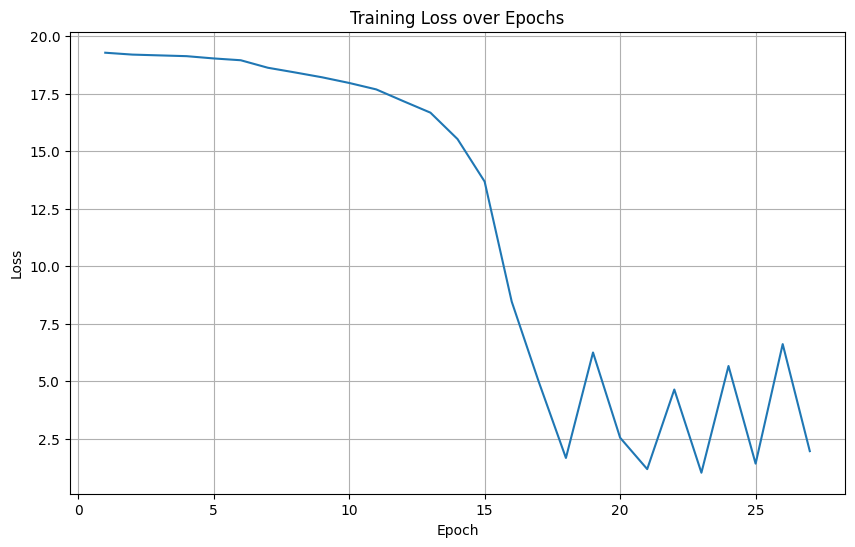

In [9]:
# Plot the losses
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(losses) + 1), [loss.value for loss in losses])
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [10]:
# Write the model to a file
import json

exported_model = model.export()
model_json = exported_model.model_dump_json()
print(model_json)

# Write the model to a file
with open('model_weights.json', 'w') as f:
    f.write(model_json)

Exporting model...
{"layers":[{"input_features":225,"output_features":5,"activation":"relu_activation","neurons":[{"values":[0.6989329436985595,1.249039019723437,1.1264204889661296,1.3100359981365681,0.3976737039717889,1.1862825524572798,0.74796434442675,1.340515973820429,0.44219326543351983,0.43637584369169896,1.3296454375883808,0.9582856025602015,0.8442741708829835,1.2780902294569716,0.9226763574881423,0.7603625959208007,1.328200796196609,0.9913517299498465,1.1108557867295261,0.44764068849758426,1.3072852690145393,0.6062305706649406,0.9949178130083011,1.1212015744390658,0.7459278509233918,1.098926969583689,0.700632971542126,0.6257906910608659,0.5322845620682138,1.3232608223088846,0.9737580305180237,1.2394751250788278,0.7817015187980194,1.3125640581803832,0.8258716155401092,0.3882823189517114,1.2577815716292204,0.8717329318360384,1.1667483083449393,0.8938091674976237,0.49907833793147094,0.7252543228013617,1.0338376629658506,0.5268234905222378,0.930068383611585,0.7413819901110821,0.654

In [11]:
from micrograd.nets.NeuralNet import NeuralNet
from micrograd.schemas.schemas import ModelSchema

# Read the model from the file
with open('model_weights.json', 'r') as f:
    model_json = f.read()

# Parse and validate the JSON using pydantic
model_schema = ModelSchema.model_validate_json(model_json)

# Create a new NeuralNet instance from the validated schema
imported_model = NeuralNet.from_json(model_schema)

print("Model successfully imported and validated.")


Importing model...
Imported model!
Model successfully imported and validated.


In [12]:
print(loss)
print(loss.value)
print(f'Loss: {loss.value:.4f}')
print(f'Epoch [], Loss: {loss.value:.4f}')

Val(value=0.7960, grad=1.0000, parents=(159.19965853657683 * 0.005))
0.7959982926828841
Loss: 0.7960
Epoch [], Loss: 0.7960


In [13]:
# Test the model
n = len(x_valid)
correct_guesses = 0
wrong_guesses = 0

y_pred = [model(xi) for xi in x_valid]

predictions = []

for pred in y_pred:
    if pred.value <= 0.5:
        predictions.append(0)
    else:
        predictions.append(1)
    
for i in range(n):
    # print(f'Prediction: {predictions[i]} with confidence {y_pred[i].value:.2f} for actual: {y_valid[i].value}')

    if predictions[i] == y_valid[i].value:
        correct_guesses += 1
    else:
        wrong_guesses += 1

print(f"Correct guesses: {correct_guesses}, Wrong guesses: {wrong_guesses}, Total: {n} - Accuracy: {(correct_guesses/n)*100}%")
print(f"Loss: {loss}")


Correct guesses: 23, Wrong guesses: 27, Total: 50 - Accuracy: 46.0%
Loss: Val(value=0.7960, grad=1.0000, parents=(159.19965853657683 * 0.005))


In [14]:
# Testing the imported model
# Test the model
n = len(x_valid)
correct_guesses = 0
wrong_guesses = 0

y_pred = [imported_model(xi) for xi in x_valid]

predictions = []

for pred in y_pred:
    if pred.value <= 0.5:
        predictions.append(0)
    else:
        predictions.append(1)
    
for i in range(n):
    # print(f'Prediction: {predictions[i]} with confidence {y_pred[i].value:.2f} for actual: {y_valid[i].value}')

    if predictions[i] == y_valid[i].value:
        correct_guesses += 1
    else:
        wrong_guesses += 1

print(f"Correct guesses: {correct_guesses}, Wrong guesses: {wrong_guesses}, Total: {n} - Accuracy: {(correct_guesses/n)*100}%")
print(f"Loss: {loss}")

Correct guesses: 23, Wrong guesses: 27, Total: 50 - Accuracy: 46.0%
Loss: Val(value=0.7960, grad=1.0000, parents=(159.19965853657683 * 0.005))


In [15]:
y_pred = Value(0.1)
y = Value(1.0)

loss_test = Value(0.0)
loss_test += (-(y * y_pred.log()) - ((Value(1.0)-y)*(Value(1.0)-y_pred).log()))
loss_test += (-(y * y_pred.log()) - ((Value(1.0)-y)*(Value(1.0)-y_pred).log()))


print(loss_test)

Val(value=4.6052, grad=0.0000, parents=(2.3025850929940455 + 2.3025850929940455))
